torch.Size([60000, 28, 28])
torch.Size([60000])


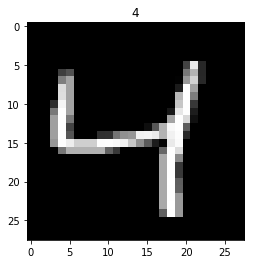

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import torch.nn.functional as F


torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 12)
        self.fc4 = nn.Linear(12 , 3)
        #self.fc5 = nn.Linear(12 , 3)
        self.fc6 = nn.Linear(3, 12)
        self.fc7 = nn.Linear(12, 64)
        self.fc8 = nn.Linear(64, 128)
        self.fc9 = nn.Linear(128, 28*28)
        
        
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))        
        x = F.tanh(self.fc3(x))        
        #x = F.tanh(self.fc4(x))        
        xe = F.tanh(self.fc4(x))        
        x = F.tanh(self.fc6(xe)) 
        x = F.tanh(self.fc7(x))                
        x = F.tanh(self.fc8(x))                
        xd = F.sigmoid(self.fc9(x))   
        
        return xe, xd
        
AE = Autoencoder()
print(AE)

Autoencoder (
  (fc1): Linear (784 -> 128)
  (fc2): Linear (128 -> 64)
  (fc3): Linear (64 -> 12)
  (fc4): Linear (12 -> 3)
  (fc6): Linear (3 -> 12)
  (fc7): Linear (12 -> 64)
  (fc8): Linear (64 -> 128)
  (fc9): Linear (128 -> 784)
)


In [17]:
optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [23]:
# initialize figure
N_TEST_IMG = 5
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

Epoch:  0 | train loss: 0.1312
Epoch:  0 | train loss: 0.0697
Epoch:  0 | train loss: 0.0637
Epoch:  0 | train loss: 0.0583
Epoch:  0 | train loss: 0.0574
Epoch:  0 | train loss: 0.0555
Epoch:  0 | train loss: 0.0527
Epoch:  0 | train loss: 0.0502
Epoch:  0 | train loss: 0.0504
Epoch:  0 | train loss: 0.0534
Epoch:  1 | train loss: 0.0452
Epoch:  1 | train loss: 0.0445
Epoch:  1 | train loss: 0.0482
Epoch:  1 | train loss: 0.0444
Epoch:  1 | train loss: 0.0423
Epoch:  1 | train loss: 0.0448
Epoch:  1 | train loss: 0.0506
Epoch:  1 | train loss: 0.0483
Epoch:  1 | train loss: 0.0452
Epoch:  1 | train loss: 0.0456
Epoch:  2 | train loss: 0.0428
Epoch:  2 | train loss: 0.0456
Epoch:  2 | train loss: 0.0438
Epoch:  2 | train loss: 0.0404
Epoch:  2 | train loss: 0.0432
Epoch:  2 | train loss: 0.0399
Epoch:  2 | train loss: 0.0378
Epoch:  2 | train loss: 0.0454
Epoch:  2 | train loss: 0.0437
Epoch:  2 | train loss: 0.0440
Epoch:  3 | train loss: 0.0438
Epoch:  3 | train loss: 0.0413
Epoch:  

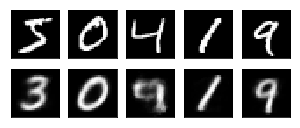

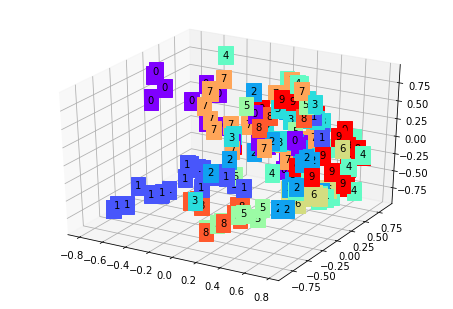

In [24]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))
        b_y = Variable(x.view(-1, 28*28))
        b_label = Variable(y)
        
        encoded, decoded = AE(b_x)
        
        loss = loss_func(decoded, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = AE(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

# visualize in 3D plot
view_data = Variable(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = AE(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()